# RE 400

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

In [ ]:
# Gauss-Seidel method with successive over-relaxation (SOR)
def SOR_method(u, h, f,omega=1.9):
    u_new = np.copy(u)
    for i in range(1, len(u[0])-1):
        for j in range(1, len(u[0])-1):
            u_new[i, j] = (1 - omega) * u[i, j] + omega * (u_new[i+1, j] + u_new[i-1, j] + u_new[i, j+1] + u_new[i, j-1] - h**2 * f[i-1, j-1]) / 4
    return u_new


In [ ]:
# initial conditions

# Space
H = 1
dx = H/128  # grid spacing
nx = int(H / dx)+1  # number of grid points in x-direction
X,Y = np.meshgrid(np.linspace(0, H, nx), np.linspace(0, H, nx))

print(nx)

# Time
dt = 0.01  # time step

# Physical parameters
nu = 1/400  # kinematic viscosity
beta = nu * dt / (2*dx**2)
   
# Initial conditions
u_lid = 1
u_field = np.zeros((nx+1, nx))
v_field = np.zeros((nx, nx+1))

u_field[-1, :] = 2*u_lid  # Set the lid velocity

u_field_old = np.zeros((nx+1, nx))
v_field_old = np.zeros((nx, nx+1))

u_field_list = [u_field_old, u_field]
v_field_list = [v_field_old, v_field]

reynolds_number = u_lid * H / nu
print(f"Reynolds number: {reynolds_number}")

In [ ]:
Lx = np.zeros((nx-2, nx-2))
Ix = np.eye(nx-2)

for i in range(nx-2):
    Lx[i, i] = -2

    if i == 0:
        Lx[i, i+1] = 1
    elif i == nx-3:
        Lx[i, i-1] = 1
    else:
        Lx[i, i-1] = 1
        Lx[i, i+1] = 1
Ax = (Ix - beta * Lx)

Ly = np.zeros((nx-1, nx-1))
Iy = np.eye(nx-1)

for i in range(nx-1):
    Ly[i, i] = -2

    if i == 0:
        Ly[i, i+1] = 1
    elif i == nx-2:
        Ly[i, i-1] = 1
    else:
        Ly[i, i-1] = 1
        Ly[i, i+1] = 1

Ay = (Iy - beta * Ly)

In [ ]:
i=1
u_field_list = [u_field_old, u_field]
v_field_list = [v_field_old, v_field]

v_bar = (v_field_list[-1][:-1,:-1]+v_field_list[-1][1:,:-1]+v_field_list[-1][:-1,1:]+v_field_list[-1][1:,1:])/4
v_bar_old = (v_field_list[-2][:-1,:-1]+v_field_list[-2][1:,:-1]+v_field_list[-2][:-1,1:]+v_field_list[-2][1:,1:])/4

# u* 구하기
S = -3/2 * (u_field_list[-1][1:-1, 1:-1] * (u_field_list[-1][1:-1, 2:] - u_field_list[-1][1:-1, :-2]) / (2*dx) + #대류항
                v_bar[:, 1:-1] * (u_field_list[-1][2:,1:-1] - u_field_list[-1][:-2,1:-1]) / (2*dx)) \
        + 1/2 * (u_field_list[-2][1:-1, 1:-1]*(u_field_list[-2][1:-1, 2:] - u_field_list[-2][1:-1, :-2]) / (2*dx) + 
                v_bar_old[:, 1:-1] * (u_field_list[-2][2:,1:-1] - u_field_list[-2][:-2,1:-1]) / (2*dx))

Ix_Lx = ((Ix  + beta * Lx) @ u_field_list[-1][1:-1, 1:-1].T).T
Ix_Lx[:,0] = Ix_Lx[:,0] + beta * (u_field_list[-1][1:-1, 0])
Ix_Lx[:,-1] = Ix_Lx[:,-1] + beta * (u_field_list[-1][1:-1, -1])


R = dt*S + (Iy + beta * Ly) @ Ix_Lx

R[0,:] = R[0,:] + beta * (beta * u_field_list[-1][0, :-2] + (1-2*beta) * u_field_list[-1][0, 1:-1] + beta * u_field_list[-1][0, 2:]) # 어차피 다 0임
R[-1,:] = R[-1,:] + beta * (beta * u_field_list[-1][-1, :-2] + (1-2*beta) * u_field_list[-1][-1, 1:-1] + beta * u_field_list[-1][-1, 2:]) # 얜 0 아님

R[0,:] = R[0,:] + beta * (-beta * u_field_list[-1][0, :-2] + (1+2*beta) * u_field_list[-1][0, 1:-1] - beta * u_field_list[-1][0, 2:]) # u_n+1일 때 값을 넣어야 하는데 어차피 넣는 것들이 경계 조건을 넣는거라 그냥 u의 값을 사용.
R[-1,:] = R[-1,:] + beta * (-beta * u_field_list[-1][-1, :-2] + (1+2*beta) * u_field_list[-1][-1, 1:-1] - beta * u_field_list[-1][-1, 2:]) # 얘도 0 아님

psi = np.linalg.solve(Ay, R)
psi[:,0] = psi[:,0] + beta * (u_field_list[-1][1:-1, 0]) # 어차피 다 0임
psi[:,-1] = psi[:,-1] + beta * (u_field_list[-1][1:-1, -1]) # 어차피 다 0임

u_trash = psi @ np.linalg.inv((Ix - beta * Lx).T)

u_sta = np.zeros((nx+1, nx))
u_sta[1:-1, 1:-1] = u_trash

# boundary conditions
u_sta[0,:] = -u_sta[1,]  # bottom wall
u_sta[-1,:] = 2-u_sta[-2,:]  # top wall


# v* 구하기
u_bar = (u_field_list[-1][:-1,:-1]+u_field_list[-1][1:,:-1]+u_field_list[-1][:-1,1:]+u_field_list[-1][1:,1:])/4
u_bar_old = (u_field_list[-2][:-1,:-1]+u_field_list[-2][1:,:-1]+u_field_list[-2][:-1,1:]+u_field_list[-2][1:,1:])/4

S = -3/2 * (u_bar[1:-1, :] * (v_field_list[-1][1:-1, 2:] - v_field_list[-1][1:-1, :-2]) / (2*dx) + 
                v_field_list[-1][1:-1, 1:-1] * (v_field_list[-1][2:,1:-1] - v_field_list[-1][:-2,1:-1]) / (2*dx)) \
        + 1/2 * (u_bar_old[1:-1, :]*(v_field_list[-2][1:-1, 2:] - v_field_list[-2][1:-1, :-2]) / (2*dx) + 
                v_field_list[-2][1:-1, 1:-1] * (v_field_list[-2][2:,1:-1] - v_field_list[-2][:-2,1:-1]) / (2*dx))

Iy_Ly = ((Iy  + beta * Ly) @ v_field_list[-1][1:-1, 1:-1].T).T
Iy_Ly[:,0] = Iy_Ly[:,0] + beta * (v_field_list[-1][1:-1, 0])
Iy_Ly[:,-1] = Iy_Ly[:,-1] + beta * (v_field_list[-1][1:-1, -1])

R = dt*S + (Ix + beta * Lx) @ Iy_Ly
R[0,:] = R[0,:] + beta * (beta * v_field_list[-1][0, :-2] + (1-2*beta) * v_field_list[-1][0, 1:-1] + beta * v_field_list[-1][0, 2:])
R[-1,:] = R[-1,:] + beta * (beta * v_field_list[-1][-1, :-2] + (1-2*beta) * v_field_list[-1][-1, 1:-1] + beta * v_field_list[-1][-1, 2:]) 

R[0,:] = R[0,:] + beta * (-beta * v_field_list[-1][0, :-2] + (1+2*beta) * v_field_list[-1][0, 1:-1] - beta * v_field_list[-1][0, 2:]) # u_n+1일 때 값을 넣어야 하는데 어차피 넣는 것들이 경계 조건을 넣는거라 그냥 u의 값을 사용.
R[-1,:] = R[-1,:] + beta * (-beta * v_field_list[-1][-1, :-2] + (1+2*beta) * v_field_list[-1][-1, 1:-1] - beta * v_field_list[-1][-1, 2:])

psi = np.linalg.solve(Ax, R)
psi[:,0] = psi[:,0] + beta * (v_field_list[-1][1:-1, 0])
psi[:,-1] = psi[:,-1] + beta * (v_field_list[-1][1:-1, -1])

v_trash = psi @ np.linalg.inv((Iy - beta * Ly).T)

v_sta = np.zeros((nx, nx+1))
v_sta[1:-1, 1:-1] = v_trash

# boundary conditions
v_sta[:,0] = -v_sta[:, 1]  # bottom wall
v_sta[:,-1] = -v_sta[:,-2]  # top wall

# du*/dx 중앙 차분법 안씀
u_sta_dx = (u_sta[1:-1, 1:] - u_sta[1:-1, :-1]) / (dx)
v_sta_dy = (v_sta[1:, 1:-1] - v_sta[:-1, 1:-1]) / (dx)

del_u = u_sta_dx + v_sta_dy

pi = np.zeros((nx+1, nx+1))

pi_list = [pi, SOR_method(pi, dx, del_u)]
iter = 0
while np.linalg.norm(pi_list[-1] - pi_list[-2]) > 1e-5:
        iter += 1
        pi_new = SOR_method(pi_list[-1], dx, del_u)  # 새로운 pi 계산
        pi_new[:,0] = pi_new[:,1] #pi_경계조건? 
        pi_new[:,-1] = pi_new[:,-2]
        pi_new[0,:] = pi_new[1,:]
        pi_new[-1,:] = pi_new[-2,:]
        pi_list.append(pi_new)  # 리스트에 추가

# u_n+1 찾기
u_field_new = np.zeros((nx+1, nx))
u_gar = u_sta[1:-1,1:-1] - (pi_list[-1][1:-1,2:-1]-pi_list[-1][1:-1,1:-2])/dx
u_field_new[1:-1,1:-1] = u_gar
u_field_new[0,:] = -u_field_new[1,]  # bottom wall
u_field_new[-1,:] = 2-u_field_new[-2,:]  # top wall
u_field_list.append(u_field_new)

# v_n+1 찾기
v_field_new = np.zeros((nx, nx+1))
v_gar = v_sta[1:-1,1:-1] - (pi_list[-1][2:-1,1:-1]-pi_list[-1][1:-2,1:-1])/dx
v_field_new[1:-1,1:-1] = v_gar
v_field_new[:,0] = -v_field_new[:,1]  # left wall
v_field_new[:,-1] = -v_field_new[:,-2]  # right wall
v_field_list.append(v_field_new)


In [ ]:
t = [-dt,0]

u_field_list = [u_field_old, u_field]
v_field_list = [v_field_old, v_field]

for i in tqdm(range(1, 1002)):
    t.append(t[-1] + dt) 
    v_bar = (v_field_list[-1][:-1,:-1]+v_field_list[-1][1:,:-1]+v_field_list[-1][:-1,1:]+v_field_list[-1][1:,1:])/4
    v_bar_old = (v_field_list[-2][:-1,:-1]+v_field_list[-2][1:,:-1]+v_field_list[-2][:-1,1:]+v_field_list[-2][1:,1:])/4

    # u* 구하기
    S = -3/2 * (u_field_list[-1][1:-1, 1:-1] * (u_field_list[-1][1:-1, 2:] - u_field_list[-1][1:-1, :-2]) / (2*dx) + 
                    v_bar[:, 1:-1] * (u_field_list[-1][2:,1:-1] - u_field_list[-1][:-2,1:-1]) / (2*dx)) \
            + 1/2 * (u_field_list[-2][1:-1, 1:-1]*(u_field_list[-2][1:-1, 2:] - u_field_list[-2][1:-1, :-2]) / (2*dx) + 
                    v_bar_old[:, 1:-1] * (u_field_list[-2][2:,1:-1] - u_field_list[-2][:-2,1:-1]) / (2*dx))

    Ix_Lx = ((Ix  + beta * Lx) @ u_field_list[i][1:-1, 1:-1].T).T
    Ix_Lx[:,0] = Ix_Lx[:,0] + beta * (u_field_list[i][1:-1, 0])
    Ix_Lx[:,-1] = Ix_Lx[:,-1] + beta * (u_field_list[i][1:-1, -1])


    R = dt*S + (Iy + beta * Ly) @ Ix_Lx
    R[0,:] = R[0,:] + beta * (beta * u_field_list[i][0, :-2] + (1-2*beta) * u_field_list[i][0, 1:-1] + beta * u_field_list[i][0, 2:])
    R[-1,:] = R[-1,:] + beta * (beta * u_field_list[i][-1, :-2] + (1-2*beta) * u_field_list[i][-1, 1:-1] + beta * u_field_list[i][-1, 2:]) 

    R[0,:] = R[0,:] + beta * (-beta * u_field_list[i][0, :-2] + (1+2*beta) * u_field_list[i][0, 1:-1] - beta * u_field_list[i][0, 2:]) # u_n+1일 때 값을 넣어야 하는데 어차피 넣는 것들이 경계 조건을 넣는거라 그냥 u의 값을 사용.
    R[-1,:] = R[-1,:] + beta * (-beta * u_field_list[i][-1, :-2] + (1+2*beta) * u_field_list[i][-1, 1:-1] - beta * u_field_list[i][-1, 2:])

    psi = np.linalg.solve(Ay, R)
    psi[:,0] = psi[:,0] + beta * (u_field_list[i][1:-1, 0])
    psi[:,-1] = psi[:,-1] + beta * (u_field_list[i][1:-1, -1])

    u_trash = psi @ np.linalg.inv((Ix - beta * Lx).T)

    u_sta = np.zeros((nx+1, nx))
    u_sta[1:-1, 1:-1] = u_trash

    # boundary conditions
    u_sta[0,:] = -u_sta[1,]  # bottom wall
    u_sta[-1,:] = 2-u_sta[-2,:]  # top wall


    # v* 구하기
    u_bar = (u_field_list[-1][:-1,:-1]+u_field_list[-1][1:,:-1]+u_field_list[-1][:-1,1:]+u_field_list[-1][1:,1:])/4
    u_bar_old = (u_field_list[-2][:-1,:-1]+u_field_list[-2][1:,:-1]+u_field_list[-2][:-1,1:]+u_field_list[-2][1:,1:])/4

    S = -3/2 * (u_bar[1:-1, :] * (v_field_list[-1][1:-1, 2:] - v_field_list[-1][1:-1, :-2]) / (2*dx) + 
                v_field_list[-1][1:-1, 1:-1] * (v_field_list[-1][2:,1:-1] - v_field_list[-1][:-2,1:-1]) / (2*dx)) \
        + 1/2 * (u_bar_old[1:-1, :]*(v_field_list[-2][1:-1, 2:] - v_field_list[-2][1:-1, :-2]) / (2*dx) + 
                v_field_list[-2][1:-1, 1:-1] * (v_field_list[-2][2:,1:-1] - v_field_list[-2][:-2,1:-1]) / (2*dx))
    
    Iy_Ly = ((Iy  + beta * Ly) @ v_field_list[-1][1:-1, 1:-1].T).T
    Iy_Ly[:,0] = Iy_Ly[:,0] + beta * (v_field_list[-1][1:-1, 0])
    Iy_Ly[:,-1] = Iy_Ly[:,-1] + beta * (v_field_list[-1][1:-1, -1])
    R = dt*S + (Ix + beta * Lx) @ Iy_Ly
    R[0,:] = R[0,:] + beta * (beta * v_field_list[-1][0, :-2] + (1-2*beta) * v_field_list[-1][0, 1:-1] + beta * v_field_list[-1][0, 2:])
    R[-1,:] = R[-1,:] + beta * (beta * v_field_list[-1][-1, :-2] + (1-2*beta) * v_field_list[-1][-1, 1:-1] + beta * v_field_list[-1][-1, 2:]) 

    R[0,:] = R[0,:] + beta * (-beta * v_field_list[-1][0, :-2] + (1+2*beta) * v_field_list[-1][0, 1:-1] - beta * v_field_list[-1][0, 2:]) # u_n+1일 때 값을 넣어야 하는데 어차피 넣는 것들이 경계 조건을 넣는거라 그냥 u의 값을 사용.
    R[-1,:] = R[-1,:] + beta * (-beta * v_field_list[-1][-1, :-2] + (1+2*beta) * v_field_list[-1][-1, 1:-1] - beta * v_field_list[-1][-1, 2:])

    psi = np.linalg.solve(Ax, R)
    psi[:,0] = psi[:,0] + beta * (v_field_list[-1][1:-1, 0])
    psi[:,-1] = psi[:,-1] + beta * (v_field_list[-1][1:-1, -1])

    v_trash = psi @ np.linalg.inv((Iy - beta * Ly).T)

    v_sta = np.zeros((nx, nx+1))
    v_sta[1:-1, 1:-1] = v_trash

    # boundary conditions
    v_sta[:,0] = -v_sta[:, 1]  # bottom wall
    v_sta[:,-1] = -v_sta[:,-2]  # top wall

    # du*/dx 중앙 차분법 안씀
    u_sta_dx = (u_sta[1:-1, 1:] - u_sta[1:-1, :-1]) / (dx)
    v_sta_dy = (v_sta[1:, 1:-1] - v_sta[:-1, 1:-1]) / (dx)

    del_u = u_sta_dx + v_sta_dy

    pi = np.zeros((nx+1, nx+1))

    pi_list = [pi, SOR_method(pi, dx, del_u)]
    iter = 0 
    while np.linalg.norm(pi_list[-1] - pi_list[-2]) > 1e-5 :
            iter += 1
            pi_new = SOR_method(pi_list[-1], dx, del_u)  # 새로운 pi 계산
            pi_new[:,0] = pi_new[:,1] #pi_경계조건? 
            pi_new[:,-1] = pi_new[:,-2]
            pi_new[0,:] = pi_new[1,:]
            pi_new[-1,:] = pi_new[-2,:]
            pi_list.append(pi_new)  # 리스트에 추가

    # u_n+1 찾기
    u_field_new = np.zeros((nx+1, nx))
    u_gar = u_sta[1:-1,1:-1] - (pi_list[-1][1:-1,2:-1]-pi_list[-1][1:-1,1:-2])/dx
    u_field_new[1:-1,1:-1] = u_gar
    u_field_new[0,:] = -u_field_new[1,]  # bottom wall
    u_field_new[-1,:] = 2-u_field_new[-2,:]  # top wall
    u_field_list.append(u_field_new)

    # v_n+1 찾기
    v_field_new = np.zeros((nx, nx+1))
    v_gar = v_sta[1:-1,1:-1] - (pi_list[-1][2:-1,1:-1]-pi_list[-1][1:-2,1:-1])/dx
    v_field_new[1:-1,1:-1] = v_gar
    v_field_new[:,0] = -v_field_new[:,1]  # left wall
    v_field_new[:,-1] = -v_field_new[:,-2]  # right wall
    v_field_list.append(v_field_new)
    
    u_field_mean = (u_field_new[1:,:]+u_field_new[:-1,:])/2
    v_field_mean = (v_field_new[:,1:]+v_field_new[:, :-1])/2

    np.save(f'C:/Users/parky/Desktop/과제 및 자료들/source code/Final Project/RE400/u{t[-1]}', u_field_mean)
    np.save(f'C:/Users/parky/Desktop/과제 및 자료들/source code/Final Project/RE400/v{t[-1]}', v_field_mean)

    time.sleep(0.01)  # Simulate some processing time

In [ ]:
u_field_mean.shape, v_field_mean.shape

In [ ]:
u_field_mean = (u_field_list[-1][1:,:]+u_field_list[-1][:-1,:])/2
v_field_mean = (v_field_list[-1][:,1:]+v_field_list[-1][:, :-1])/2

In [ ]:
u_field_mean[64,:]

In [ ]:
u_field_mean

In [ ]:
v_field_mean

In [ ]:
u = np.sqrt(u_field_mean**2 + v_field_mean**2)
X, Y = np.meshgrid(np.linspace(0, H, nx), np.linspace(0, H, nx))
plt.figure(figsize=(10, 8))
plt.contourf(X, Y, u, levels=50, cmap='viridis')
plt.streamplot(X, Y, u_field_mean, v_field_mean, color='white')
plt.colorbar(label='Velocity Magnitude')
plt.xlim(0, H)
plt.ylim(0, H)

# RE 100

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from numba import jit
import time

In [9]:
# Gauss-Seidel method with successive over-relaxation (SOR)
@jit
def SOR_method(u, h, f,omega=1.9):
    u_new = np.copy(u)
    for i in range(1, len(u[0])-1):
        for j in range(1, len(u[0])-1):
            u_new[i, j] = (1 - omega) * u[i, j] + omega * (u_new[i+1, j] + u_new[i-1, j] + u_new[i, j+1] + u_new[i, j-1] - h**2 * f[i-1, j-1]) / 4
    return u_new


In [10]:
# initial conditions

# Space
H = 1
dx = H/128  # grid spacing
nx = int(H / dx)+1  # number of grid points in x-direction
X,Y = np.meshgrid(np.linspace(0, H, nx), np.linspace(0, H, nx))

print(nx)

# Time
dt = 0.01  # time step

# Physical parameters
nu = 1/100  # kinematic viscosity
beta = nu * dt / (2*dx**2)
   
# Initial conditions
u_lid = 1
u_field = np.zeros((nx+1, nx))
v_field = np.zeros((nx, nx+1))

u_field[-1, :] = 2*u_lid  # Set the lid velocity

u_field_old = np.zeros((nx+1, nx))
v_field_old = np.zeros((nx, nx+1))

u_field_list = [u_field_old, u_field]
v_field_list = [v_field_old, v_field]

reynolds_number = u_lid * H / nu
print(f"Reynolds number: {reynolds_number}")

129
Reynolds number: 100.0


In [11]:
Lx = np.zeros((nx-2, nx-2))
Ix = np.eye(nx-2)

for i in range(nx-2):
    Lx[i, i] = -2

    if i == 0:
        Lx[i, i+1] = 1
    elif i == nx-3:
        Lx[i, i-1] = 1
    else:
        Lx[i, i-1] = 1
        Lx[i, i+1] = 1
Ax = (Ix - beta * Lx)

Ly = np.zeros((nx-1, nx-1))
Iy = np.eye(nx-1)

for i in range(nx-1):
    Ly[i, i] = -2

    if i == 0:
        Ly[i, i+1] = 1
    elif i == nx-2:
        Ly[i, i-1] = 1
    else:
        Ly[i, i-1] = 1
        Ly[i, i+1] = 1

Ay = (Iy - beta * Ly)

In [ ]:
t = [-dt,0]

u_field_list = [u_field_old, u_field]
v_field_list = [v_field_old, v_field]

u_field_mean_list = [np.zeros((nx, nx))]
v_field_mean_list = [np.zeros((nx, nx))]

while True:

    t.append(t[-1] + dt) 
    v_bar = (v_field_list[-1][:-1,:-1]+v_field_list[-1][1:,:-1]+v_field_list[-1][:-1,1:]+v_field_list[-1][1:,1:])/4
    v_bar_old = (v_field_list[-2][:-1,:-1]+v_field_list[-2][1:,:-1]+v_field_list[-2][:-1,1:]+v_field_list[-2][1:,1:])/4

    # u* 구하기
    S = -3/2 * (u_field_list[-1][1:-1, 1:-1] * (u_field_list[-1][1:-1, 2:] - u_field_list[-1][1:-1, :-2]) / (2*dx) + 
                    v_bar[:, 1:-1] * (u_field_list[-1][2:,1:-1] - u_field_list[-1][:-2,1:-1]) / (2*dx)) \
            + 1/2 * (u_field_list[-2][1:-1, 1:-1]*(u_field_list[-2][1:-1, 2:] - u_field_list[-2][1:-1, :-2]) / (2*dx) + 
                    v_bar_old[:, 1:-1] * (u_field_list[-2][2:,1:-1] - u_field_list[-2][:-2,1:-1]) / (2*dx))

    Ix_Lx = ((Ix  + beta * Lx) @ u_field_list[-1][1:-1, 1:-1].T).T
    Ix_Lx[:,0] = Ix_Lx[:,0] + beta * (u_field_list[-1][1:-1, 0])
    Ix_Lx[:,-1] = Ix_Lx[:,-1] + beta * (u_field_list[-1][1:-1, -1])


    R = dt*S + (Iy + beta * Ly) @ Ix_Lx
    R[0,:] = R[0,:] + beta * (beta * u_field_list[-1][0, :-2] + (1-2*beta) * u_field_list[-1][0, 1:-1] + beta * u_field_list[-1][0, 2:])
    R[-1,:] = R[-1,:] + beta * (beta * u_field_list[-1][-1, :-2] + (1-2*beta) * u_field_list[-1][-1, 1:-1] + beta * u_field_list[-1][-1, 2:])

    R[0,:] = R[0,:] + beta * (-beta * u_field_list[-1][0, :-2] + (1+2*beta) * u_field_list[-1][0, 1:-1] - beta * u_field_list[-1][0, 2:]) # u_n+1일 때 값을 넣어야 하는데 어차피 넣는 것들이 경계 조건을 넣는거라 그냥 u의 값을 사용.
    R[-1,:] = R[-1,:] + beta * (-beta * u_field_list[-1][-1, :-2] + (1+2*beta) * u_field_list[-1][-1, 1:-1] - beta * u_field_list[-1][-1, 2:])

    psi = np.linalg.solve(Ay, R)
    psi[:,0] = psi[:,0] + beta * (u_field_list[-1][1:-1, 0])
    psi[:,-1] = psi[:,-1] + beta * (u_field_list[-1][1:-1, -1])

    u_trash = psi @ np.linalg.inv((Ix - beta * Lx).T)

    u_sta = np.zeros((nx+1, nx))
    u_sta[1:-1, 1:-1] = u_trash

    # boundary conditions
    u_sta[0,:] = -u_sta[1,]  # bottom wall
    u_sta[-1,:] = 2-u_sta[-2,:]  # top wall


    # v* 구하기
    u_bar = (u_field_list[-1][:-1,:-1]+u_field_list[-1][1:,:-1]+u_field_list[-1][:-1,1:]+u_field_list[-1][1:,1:])/4
    u_bar_old = (u_field_list[-2][:-1,:-1]+u_field_list[-2][1:,:-1]+u_field_list[-2][:-1,1:]+u_field_list[-2][1:,1:])/4

    S = -3/2 * (u_bar[1:-1, :] * (v_field_list[-1][1:-1, 2:] - v_field_list[-1][1:-1, :-2]) / (2*dx) + 
                v_field_list[-1][1:-1, 1:-1] * (v_field_list[-1][2:,1:-1] - v_field_list[-1][:-2,1:-1]) / (2*dx)) \
        + 1/2 * (u_bar_old[1:-1, :]*(v_field_list[-2][1:-1, 2:] - v_field_list[-2][1:-1, :-2]) / (2*dx) + 
                v_field_list[-2][1:-1, 1:-1] * (v_field_list[-2][2:,1:-1] - v_field_list[-2][:-2,1:-1]) / (2*dx))
    
    Iy_Ly = ((Iy  + beta * Ly) @ v_field_list[-1][1:-1, 1:-1].T).T
    Iy_Ly[:,0] = Iy_Ly[:,0] + beta * (v_field_list[-1][1:-1, 0])
    Iy_Ly[:,-1] = Iy_Ly[:,-1] + beta * (v_field_list[-1][1:-1, -1])
    R = dt*S + (Ix + beta * Lx) @ Iy_Ly
    R[0,:] = R[0,:] + beta * (beta * v_field_list[-1][0, :-2] + (1-2*beta) * v_field_list[-1][0, 1:-1] + beta * v_field_list[-1][0, 2:])
    R[-1,:] = R[-1,:] + beta * (beta * v_field_list[-1][-1, :-2] + (1-2*beta) * v_field_list[-1][-1, 1:-1] + beta * v_field_list[-1][-1, 2:]) 

    R[0,:] = R[0,:] + beta * (-beta * v_field_list[-1][0, :-2] + (1+2*beta) * v_field_list[-1][0, 1:-1] - beta * v_field_list[-1][0, 2:]) # u_n+1일 때 값을 넣어야 하는데 어차피 넣는 것들이 경계 조건을 넣는거라 그냥 u의 값을 사용.
    R[-1,:] = R[-1,:] + beta * (-beta * v_field_list[-1][-1, :-2] + (1+2*beta) * v_field_list[-1][-1, 1:-1] - beta * v_field_list[-1][-1, 2:])

    psi = np.linalg.solve(Ax, R)
    psi[:,0] = psi[:,0] + beta * (v_field_list[-1][1:-1, 0])
    psi[:,-1] = psi[:,-1] + beta * (v_field_list[-1][1:-1, -1])

    v_trash = psi @ np.linalg.inv((Iy - beta * Ly).T)

    v_sta = np.zeros((nx, nx+1))
    v_sta[1:-1, 1:-1] = v_trash

    # boundary conditions
    v_sta[:,0] = -v_sta[:, 1]  # bottom wall
    v_sta[:,-1] = -v_sta[:,-2]  # top wall

    # du*/dx 중앙 차분법 안씀
    u_sta_dx = (u_sta[1:-1, 1:] - u_sta[1:-1, :-1]) / (dx)
    v_sta_dy = (v_sta[1:, 1:-1] - v_sta[:-1, 1:-1]) / (dx)

    del_u = u_sta_dx + v_sta_dy

    pi = np.zeros((nx+1, nx+1))

    pi_list = [pi, SOR_method(pi, dx, del_u)]
    iter = 0 
    while np.linalg.norm(pi_list[-1] - pi_list[-2]) > 1e-5 :
            iter += 1
            pi_new = SOR_method(pi_list[-1], dx, del_u)  # 새로운 pi 계산
            pi_new[:,0] = pi_new[:,1] #pi_경계조건? 
            pi_new[:,-1] = pi_new[:,-2]
            pi_new[0,:] = pi_new[1,:]
            pi_new[-1,:] = pi_new[-2,:]
            pi_list.append(pi_new)  # 리스트에 추가

    # u_n+1 찾기
    u_field_new = np.zeros((nx+1, nx))
    u_gar = u_sta[1:-1,1:-1] - (pi_list[-1][1:-1,2:-1]-pi_list[-1][1:-1,1:-2])/dx
    u_field_new[1:-1,1:-1] = u_gar
    u_field_new[0,:] = -u_field_new[1,]  # bottom wall
    u_field_new[-1,:] = 2-u_field_new[-2,:]  # top wall
    u_field_list.append(u_field_new)

    # v_n+1 찾기
    v_field_new = np.zeros((nx, nx+1))
    v_gar = v_sta[1:-1,1:-1] - (pi_list[-1][2:-1,1:-1]-pi_list[-1][1:-2,1:-1])/dx
    v_field_new[1:-1,1:-1] = v_gar
    v_field_new[:,0] = -v_field_new[:,1]  # left wall
    v_field_new[:,-1] = -v_field_new[:,-2]  # right wall
    v_field_list.append(v_field_new)
    
    u_field_mean = (u_field_new[1:,:]+u_field_new[:-1,:])/2
    v_field_mean = (v_field_new[:,1:]+v_field_new[:, :-1])/2


    print(f"\rtime: {t[-1]}", end='', flush=True)
    time.sleep(0.01)

    u_field_mean_list.append(u_field_mean)
    v_field_mean_list.append(v_field_mean)

    u_new = np.square(u_field_list[-1]**2 + v_field_list[-1]**2)
    u_old = np.square(u_field_list[-2]**2 + v_field_list[-2]**2)

    del u_field_mean_list[0]
    del v_field_mean_list[0]
    
    if np.linalg.norm(u_new - u_old) < 1e-5:
        break
np.save(f'C:/Users/User/OneDrive - 인천광역시교육청/바탕 화면/CSE/code/Final Project/Re1000/u{t[-1]}', u_field_mean)
np.save(f'C:/Users/User/OneDrive - 인천광역시교육청/바탕 화면/CSE/code/Final Project/Re1000/v{t[-1]}', v_field_mean)

100%|██████████| 1001/1001 [05:13<00:00,  3.19it/s]


In [13]:
#Plot
import time
import os
import re

files = os.listdir('C:/Users/parky/Desktop/과제 및 자료들/source code/Final Project/RE100/')

H = 1
dx = H/128  # grid spacing
nx = int(H / dx)+1  # number of grid points in x-direction

u_files = [f for f in files if f.startswith('u')]
v_files = [f for f in files if f.startswith('v')]

u_name, v_name = u_files[-1], v_files[-1]

u_field_mean = np.load(f'C:/Users/parky/Desktop/과제 및 자료들/source code/Final Project/RE100/{u_name}')
v_field_mean = np.load(f'C:/Users/parky/Desktop/과제 및 자료들/source code/Final Project/RE100/{v_name}')

Text(0.5, 1.0, 'Lid-driven Cavitiy Velocity Field at Reynodls 100. Time[s] = 10.00')

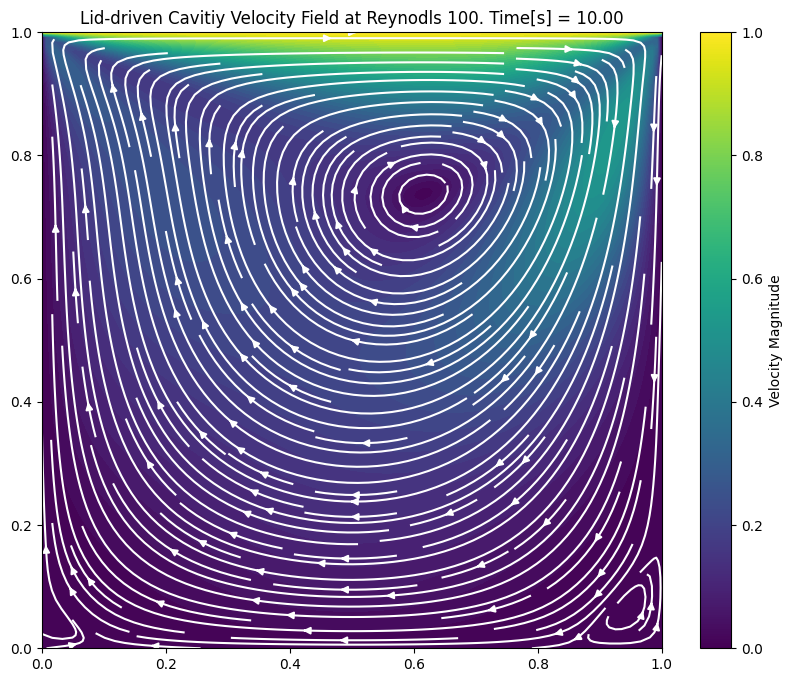

In [14]:
u = np.sqrt(u_field_mean**2 + v_field_mean**2)
X, Y = np.meshgrid(np.linspace(0, H, nx), np.linspace(0, H, nx))
plt.figure(figsize=(10, 8))
plt.contourf(X, Y, u, levels=50, cmap='viridis')
plt.streamplot(X, Y, u_field_mean, v_field_mean, color='white',density=2)
plt.colorbar(label='Velocity Magnitude')
plt.xlim(0, H)
plt.ylim(0, H)
plt.title(f'Lid-driven Cavitiy Velocity Field at Reynodls 100. Time[s] = {float(u_name[1:-4]):.2f}')

# Re=1000